Install all the dependancies
1. EasyOCR (An optical character recognition API)
2. Strsim (Library for calculating text distances)
3. Multi-Template-Matching (For image template matching)

In [ ]:
!pip install easyocr

In [ ]:
!pip install strsim

In [ ]:
import torch
import cv2
import easyocr
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [ ]:
from similarity.normalized_levenshtein import NormalizedLevenshtein
from google.colab.patches import cv2_imshow

Take a good look at the dataset

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Premise Data Challenge/DataTest.csv')

In [ ]:
dataset.head()

,photo,lat,lon,how safe do you feel in this area?,how confident are you in the quality of this pharmacy?,have you ever visited this pharmacy?,is this pharmacy currently open?,have you ever gotten medication or medical supplies at this pharmacy,name
0,6216958088839168_photos/b3a89440-b279-4e86-8dc...,19.217093,-98.993166,neither safe nor unsafe,confident,yes,yes,no,medipharma
1,6216958088839168_photos/74bba2c9-f459-4b99-b17...,19.433989,-99.046441,safe,confident,no,ok,yes,Farmacia Columbia
2,6216958088839168_photos/91972442-f9a3-4c88-886...,19.369749,-99.141470,safe,confident,no,ok,yes,Farmacia Benavides
3,6216958088839168_photos/105bf406-509c-47cf-bc8...,19.456431,-99.215366,neither safe nor unsafe,i do not know,no,ok,yes,Farmacia del Ahorro
4,6216958088839168_photos/99a3696f-28a6-45d7-880...,19.478893,-99.189080,unsafe,i do not know,no,ok,yes,Farmacias Gi


In [ ]:
photo_name = dataset[['photo','name']]

In [ ]:
photo_name.iloc[180:190]

,photo,name
180,6216958088839168_photos/b1fdb4fa-14bc-436a-a07...,G.I
181,6216958088839168_photos/7e2845b8-eb05-4778-b71...,farmacias especializadas
182,6216958088839168_photos/19dfa525-51ab-48b2-8c1...,MCB Farmacias
183,6216958088839168_photos/6f1c8ecc-842e-4806-998...,farmacias similares
184,6216958088839168_photos/1f8c8c23-878c-4904-a62...,Farmacias del Ahorro
185,6216958088839168_photos/14e851e2-c291-4853-b0f...,farmacia de la luz
186,6216958088839168_photos/2f16fe99-66b5-416c-a70...,farmacia Benavides
187,6216958088839168_photos/e9d4ff89-b691-43ab-b13...,Farmapronto
188,6216958088839168_photos/d8e3dcd2-f612-4d6d-8b8...,Farmacias Benavides
189,6216958088839168_photos/de9a6382-0b4a-46cb-b46...,pharmaclub


In [ ]:
image_path = "/content/drive/MyDrive/Premise Data Challenge/6216958088839168_photos/"

In [ ]:
photo_name.photo = photo_name.photo.str.split("/")

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
test_image_path = image_path + photo_name.iloc[184][0][1]
test_image_path

'/content/drive/MyDrive/Premise Data Challenge/6216958088839168_photos/1f8c8c23-878c-4904-a622-8b34a7a6350d.jpg'

In [ ]:
test_image_name = photo_name.name.iloc[184]
test_image_name

'Farmacias del Ahorro'

In [ ]:
test_image = cv2.imread(test_image_path)

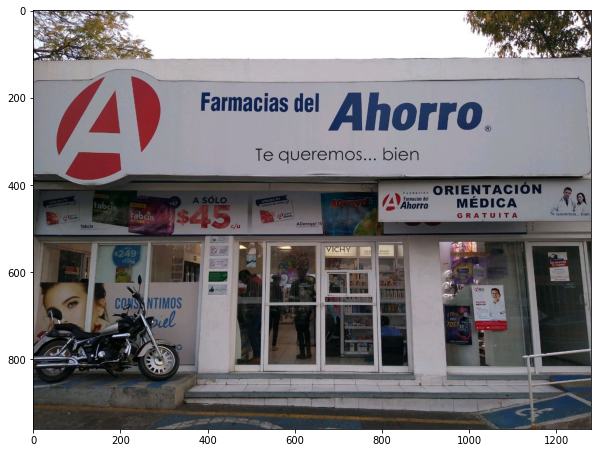

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.show()

# **OCR implementation**

The Reader class of easyocr library creates a reader object, that uses english latin characters as a default identification choice.

In [ ]:
reader = easyocr.Reader(['en'], gpu=False)
result = reader.readtext(test_image_path)

Using CPU. Note: This module is much faster with a GPU.


In [ ]:
len(result)

25

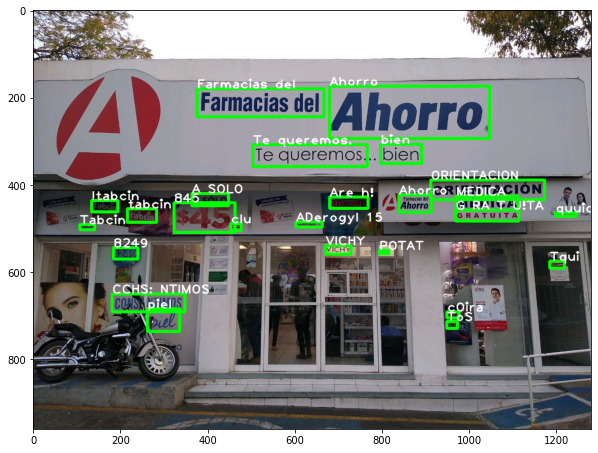

In [ ]:
bounded_test_image = test_image.copy()
for detection in result:
    top_left = tuple([int(val) for val in detection[0][0]])
    bottom_right = tuple([int(val) for val in detection[0][2]])
    text = detection[1]
    font = cv2.FONT_HERSHEY_PLAIN
    bounded_test_image = cv2.rectangle(bounded_test_image, top_left, bottom_right, (0,255,0), 5)
    bounded_test_image = cv2.putText(bounded_test_image, text, top_left, font, 2, (255,255,255), 2, cv2.LINE_AA)
    
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(bounded_test_image, cv2.COLOR_BGR2RGB))
plt.show()

As you can see in the above image, we have too many bounding boxes. Let's try to reduce them with the information provided by the contributor.

In [ ]:
clean_result = []
for i in range(len(result)):
  if(result[i][2] > 0.4):
    result[i] = list(result[i])
    result[i][1] = result[i][1].strip().split(" ")
    clean_result.append(result[i])

In [ ]:
clean_result

[[[[376, 180], [667, 180], [667, 244], [376, 244]],
  ['Farmacias', 'del'],
  0.9885258946501113],
 [[[680, 174], [1047, 174], [1047, 294], [680, 294]],
  ['Ahorro'],
  0.9999617475824778],
 [[[504, 308], [766, 308], [766, 358], [504, 358]],
  ['Te', 'queremos.'],
  0.6063737127856649],
 [[[797, 307], [891, 307], [891, 351], [797, 351]],
  ['bien'],
  0.9999963045120239],
 [[[912, 389], [1173, 389], [1173, 434], [912, 434]],
  ['ORIENTACION'],
  0.9994232936637915],
 [[[134, 436], [194, 436], [194, 462], [134, 462]],
  ['Itabcin'],
  0.814778243358294],
 [[[839, 423], [913, 423], [913, 463], [839, 463]],
  ['Ahorro'],
  0.673142636976083],
 [[[970, 426], [1112, 426], [1112, 458], [970, 458]],
  ['MEDICA'],
  0.9999406745453135],
 [[[216, 455], [283, 455], [283, 486], [216, 486]],
  ['tabcin'],
  0.9567960258603949],
 [[[323, 441], [463, 441], [463, 509], [323, 509]],
  ['845'],
  0.48839497566223145],
 [[[603, 485], [663, 485], [663, 497], [603, 497]],
  ['ADerogyl', '15'],
  0.9067932

# **Text correction**

Below is the name entry for the given image provided by the contributor. Let's calculate the normalized Levenshtein distance between that entry, and all the text output that out OCR API generates. If we find a match, retain only that portion of the text.



In [ ]:
test_image_name = test_image_name.strip().split(" ")

In [ ]:
test_image_name

['Farmacias', 'del', 'Ahorro']

In [ ]:
normalized_levenshtein = NormalizedLevenshtein()

In [ ]:
farmacia_flag = False
for i in range(len(test_image_name)):
  if(normalized_levenshtein.distance("farmacias", test_image_name[i].lower()) < 0.2):
    farmacia_flag = True
  
if(not farmacia_flag):
  test_image_name.append("farmacias")

In [ ]:
test_image_name

['Farmacias', 'del', 'Ahorro']

In [ ]:
for i in range(len(clean_result)):
  print(clean_result[i][1])

['Farmacias', 'del']
['Ahorro']
['Te', 'queremos.']
['bien']
['ORIENTACION']
['Itabcin']
['Ahorro']
['MEDICA']
['tabcin']
['845']
['ADerogyl', '15']
['Tabcin']
['clu']
['8249']
['VICHY']
['piel']
['ToS']


In [ ]:
final_result = []
for i in range(len(clean_result)):
  append_flag = True
  for j in range(len(clean_result[i][1])):
    for k in range(len(test_image_name)):
      if(normalized_levenshtein.distance(clean_result[i][1][j].lower(), test_image_name[k].lower()) <= 0.25):
        clean_result[i][1] = " ".join(clean_result[i][1])
        final_result.append(tuple(clean_result[i]))
        append_flag = False
        break
    if(append_flag == False):
      break

These are the only 3 text outputs which our post-processing algorithm retains.

In [ ]:
final_result

[([[376, 180], [667, 180], [667, 244], [376, 244]],
  'Farmacias del',
  0.9885258946501113),
 ([[680, 174], [1047, 174], [1047, 294], [680, 294]],
  'Ahorro',
  0.9999617475824778),
 ([[839, 423], [913, 423], [913, 463], [839, 463]],
  'Ahorro',
  0.673142636976083)]

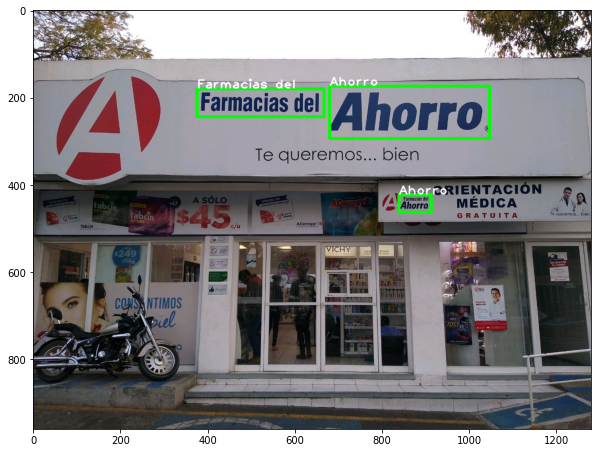

In [ ]:
final_image = test_image.copy()
for detection in final_result:
    top_left = tuple([int(val) for val in detection[0][0]])
    bottom_right = tuple([int(val) for val in detection[0][2]])
    text = detection[1]
    font = cv2.FONT_HERSHEY_PLAIN
    final_image = cv2.rectangle(final_image, top_left, bottom_right, (0,255,0), 5)
    final_image = cv2.putText(final_image, text, top_left, font, 2, (255,255,255), 2, cv2.LINE_AA)
    
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
plt.show()

You can see that a  lot of the text from previous image has been thrown away.

In [ ]:
!pip install Multi-Template-Matching

# **Template Matcher**

Additionally, we can use some logos to identify the brand of the pharmacy in case the text is not clearly visible.

In [ ]:
import MTM
print("MTM version : ", MTM.__version__)

from MTM import matchTemplates, drawBoxesOnRGB
from MTM.NMS import NMS

import cv2
print("Opencv version: ", cv2.__version__)
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

MTM version :  1.6.1
Opencv version:  4.1.2


In [ ]:
template_image = cv2.imread('/content/drive/MyDrive/Premise Data Challenge/Templates/template3.jpg')

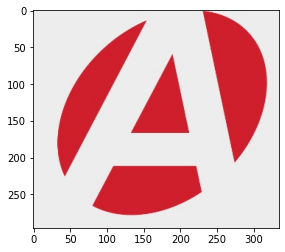

In [ ]:
plt.imshow(cv2.cvtColor(template_image, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
listTemplate = [('template_image', template_image)]

In [ ]:
Hits = matchTemplates(listTemplate, test_image, N_object=10,score_threshold=0.25, method=cv2.TM_CCOEFF_NORMED, maxOverlap=0.3)
print("Found {} hits".format( len(Hits.index) ) )
Hits

Found 1 hits


,TemplateName,BBox,Score
0,template_image,"(0, 114, 334, 296)",0.277944


In [ ]:
if(len(Hits) > 0):
  Hits = Hits[:1]

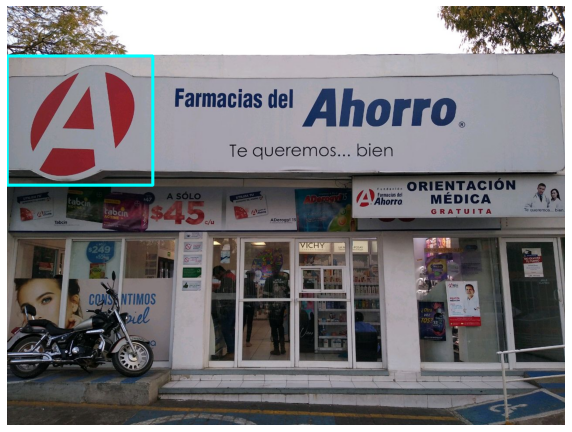

In [ ]:
if(len(Hits) > 0):
  Overlay = drawBoxesOnRGB(test_image, Hits, boxThickness=5)
  plt.figure(figsize = (10,10))
  plt.axis("off")
  plt.imshow(cv2.cvtColor(Overlay, cv2.COLOR_BGR2RGB))
  plt.show()